# Load Data

In [ ]:
!pip install -q --upgrade gdown --no-cache-dir

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!unzip -q train_data1200.zip
!unzip -q train_data600.zip
!unzip -q final_test_dataset.zip

unzip:  cannot find or open train_data1200.zip, train_data1200.zip.zip or train_data1200.zip.ZIP.
unzip:  cannot find or open train_data600.zip, train_data600.zip.zip or train_data600.zip.ZIP.
unzip:  cannot find or open final_test_dataset.zip, final_test_dataset.zip.zip or final_test_dataset.zip.ZIP.


# Import Modules

In [ ]:
!pip install -q min2net

     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 1.0 MB 30.8 MB/s 


In [ ]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from seaborn import heatmap
import scipy.signal as signal
from scipy.fft import rfft, rfftfreq
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, \
MaxPooling2D, Conv1D, Conv1DTranspose, MaxPooling1D, Reshape
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from min2net.utils import TimeHistory, compute_class_weight

import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import classification_report, f1_score

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Create Giant DataFrame

In [ ]:
def load_fix_df(froot, fname, label=False):
  df = pd.read_csv(f"{froot}/{fname}")
  fr = df.columns
  if label:
    df.columns = ["filename", "label"]
    df_new = pd.DataFrame({"filename": [fr[0]], "label": [fr[1]]})
    df_new["label"] = df_new["label"].astype(int)
  else:
    df.columns = ["ax", "ay", "az"]
    df_new = pd.DataFrame({"ax": [fr[0]], "ay": [fr[1]], "az": [fr[2]]})
  df_new = pd.concat([df, df_new], axis=0, ignore_index=True)
  if not label:
    df_new = df_new.astype(float)
  df_new["root"] = [froot for _ in range(len(df_new))]
  return df_new

In [ ]:
df_600 = load_fix_df('train_data600', 'label.csv', label=True)
df_600.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29000 entries, 0 to 28999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  29000 non-null  object
 1   label     29000 non-null  int64 
 2   root      29000 non-null  object
dtypes: int64(1), object(2)
memory usage: 679.8+ KB


In [ ]:
df_600.head()

In [ ]:
df_600.tail()

In [ ]:
df_1200 = load_fix_df('train_data1200', 'label.csv', label=True)
df_1200.info()

In [ ]:
df_1200.head()

In [ ]:
df_1200.tail()

In [ ]:
df_all = pd.concat([df_600, df_1200], axis=0, ignore_index=True)
df_all.info()

# Preview Data

In [ ]:
FS = 51200
NFT = 12500


def encode_case(x):
  if x==0:
    return 0, 0
  elif x in [1, 2, 3]:
    return 1, 3
  elif x in [4, 5, 6]:
    return 2, 6
  elif x in [7, 8, 9, 10]:
    return 3, 9
  elif x in [11, 12, 13]:
    return 4, 13
  elif x in [14, 15, 16]:
    return 5, 16
  elif x in [17, 18, 19]:
    return 6, 19
  elif x in [20, 21, 22]:
    return 7, 22
  elif x in [23, 24, 25]:
    return 8, 25
  elif x in [26, 27, 28]:
    return 9, 28
  else:
    raise Exception("Invalid Fault Code")


def plot_tdomain(data, tmin=None, tmax=None, Fs=None):
  if Fs is None:
    Fs = FS
  t_axis = np.arange(len(data)) * (1/Fs)
  fig, ax = plt.subplots(1, 1, figsize=[10, 2])
  fig.tight_layout(pad=2)
  imin, imax = 0, len(data)
  if tmin is not None:
    imin = round(tmin*Fs)
  if tmax is not None:
    imax = round(tmax*Fs)
  ax.plot(t_axis[imin:imax], data[imin:imax])
  ax.set_title(f"Time Domain")
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Amplitude")
  ax.grid('on')
  plt.show()


def plot_fdomain(data, fmin=None, fmax=None, Fs=None, tmin=None, tmax=None, localize=False, power=False, subtract_mean=False):
  if Fs is None:
    Fs = FS
  imin, imax = 0, len(data)
  if tmin is not None:
    imin = round(tmin*Fs)
  if tmax is not None:
    imax = round(tmax*Fs)
  data = data[imin:imax]
  f_axis = rfftfreq(len(data), 1/Fs)
  ARR = rfft(data)
  magnitude = np.abs(ARR)**2 if power else np.abs(ARR)
  fig, ax = plt.subplots(1, 1, figsize=[10, 2])
  fig.tight_layout(pad=2)
  imin, imax = 0, len(ARR)
  if fmin is not None:
    imin = round(fmin/(Fs/2)*len(ARR))
  if fmax is not None:
    imax = round(fmax/(Fs/2)*len(ARR))
  F = f_axis[imin:imax]
  M = magnitude[imin:imax]
  if subtract_mean:
    M -= M.mean()
  if localize:
    peak_locs = signal.find_peaks(M)[0]
    peak_vals = M[peak_locs]
    M = np.zeros_like(M)
    M[peak_locs] = peak_vals
    M = (M-M.mean()) / M.std()
  ax.plot(F, M)
  ax.set_title(f"Frequency Domain")
  ax.set_xlabel("Frequency (Hz)")
  ax.set_ylabel("Power" if power else "Magnitude")
  ax.grid('on')
  plt.show()


def preview_case(case, index=None):
  global df_600
  if index is None:
    index = np.random.randint(0, 999)
  fname, _, froot = df_600[df_600['label']==case].iloc[index]
  noisy = load_fix_df(froot, fname, label=False)
  noisy = noisy[['ax', 'ay', 'az']].to_numpy().T
  _, clean_case = encode_case(case)
  clean = load_fix_df('clean_data-rpm600-duration1s', f'case{clean_case}.csv', label=False)
  clean = clean[['ax', 'ay', 'az']].to_numpy().T
  return noisy, clean[:noisy.shape[-1]]

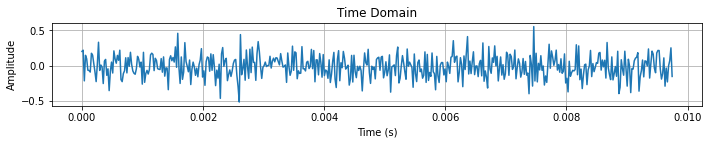

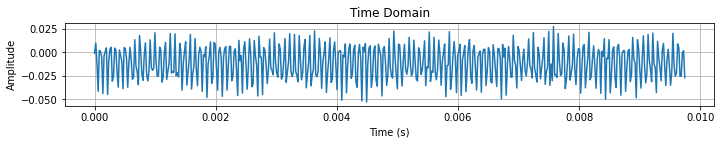

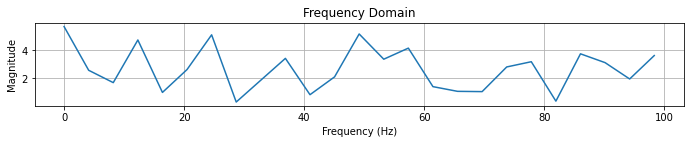

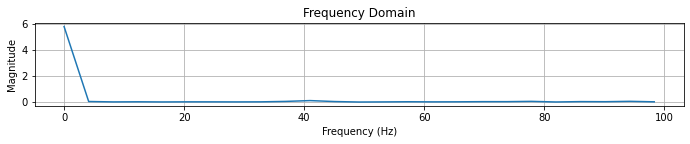

In [ ]:
case = 0  # Fault Code
axis = 0  # ax, ay, az

demo_noisy, demo_clean = preview_case(case)
noisy = signal.resample(demo_noisy[axis], 500, axis=-1)
clean = signal.resample(demo_clean[axis], 500, axis=-1)
plot_tdomain(noisy, tmax=0.05)
plot_tdomain(clean, tmax=0.05)
plot_fdomain(noisy, fmax=100, Fs=FS/(12500/500))
plot_fdomain(clean, fmax=100, Fs=FS/(12500/500))

# Model-Based Denoising

# Creating FFT Denoising

In [ ]:
(FS / (12500/500)) / 2

1024.0

In [ ]:
(500/(NFT/2)) * 1024.0

81.92

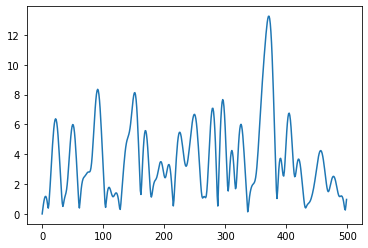

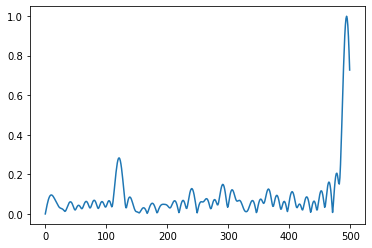

In [ ]:
case = 0  # Fault Code
axis = 0  # ax, ay, az

demo_noisy, demo_clean = preview_case(case)

_noisy = signal.resample(demo_noisy, 500, axis=-1)
_clean = signal.resample(demo_clean, 500, axis=-1)
_noisy -= _noisy.mean(axis=-1)[..., None]
_clean -= _clean.mean(axis=-1)[..., None]
_noisy = np.abs(rfft(_noisy, n=NFT, axis=-1))[:, :500]
_clean = np.abs(rfft(_clean, n=NFT, axis=-1))[:, :500]
plt.plot(_noisy[0])
plt.show()
plt.plot(_clean[0])
plt.show()

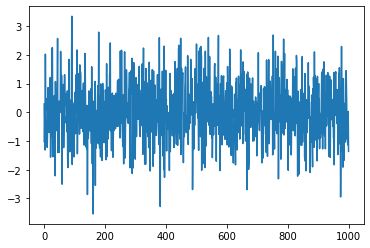

In [ ]:
import numpy
import matplotlib.pyplot as plt

mean = 0
std = 1 
num_samples = 1000
samples = numpy.random.normal(mean, std, size=num_samples)

plt.plot(samples)
plt.show()

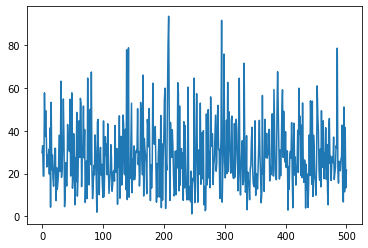

In [ ]:
A = np.fft.rfft(samples)
plt.plot(np.abs(A))
plt.show()

In [ ]:
print(rfft(_noisy, n=NFT, axis=-1).shape)

(3, 6251)


In [ ]:
std = StandardScaler()
mms = MinMaxScaler()


def preprocess_single_data(data):
  global mms
  data = signal.resample(data, 500, axis=0)
  data = np.abs(rfft(data, n=NFT, axis=0))
  data = data[:500]
  data = mms.fit_transform(data)
  return data


LABELS = []
for label in tqdm([0, 3, 6, 9, 13, 16, 19, 22, 25, 28]):
  label = load_fix_df('clean_data-rpm600-duration1s', f'case{label}.csv', label=False)
  label = np.stack([label['ax'].to_numpy(), label['ay'].to_numpy(), label['az'].to_numpy()], axis=1)
  label = preprocess_single_data(label)
  LABELS.append(label)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
class FFTDataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fname, label, froot = self.df.iloc[idx].tolist()
    fname = fname.replace('test', 'train')
    data = load_fix_df(froot, fname, label=False)
    data = np.stack([data['ax'].to_numpy(), data['ay'].to_numpy(), data['az'].to_numpy()], axis=1)
    data = preprocess_single_data(data)
    label, _ = encode_case(int(label))
    label = LABELS[label]
    return data, label

  def __call__(self):
    for i in range(self.__len__()):
      yield self.__getitem__(i)

  
class FFTDAE(tf.keras.Model):
  def __init__(self):
    super(FFTDAE, self).__init__()
    self.conv1 = Conv1D(128, 50, strides=1, padding='same', activation='relu')
    self.bn1 = BatchNormalization()
    self.pool1 = MaxPooling1D()
    self.conv2 = Conv1D(32, 50, strides=1, padding='same', activation='relu')
    self.bn2 = BatchNormalization()
    self.pool2 = MaxPooling1D()
    self.flatten = Flatten()
    self.fc1 = Dense(1600, activation='relu')
    self.fc2 = Dense(1600, activation='relu')
    self.fc3 = Dense(4000, activation='relu')
    self.reshape = Reshape((125, 32))
    self.deconv2_ = Conv1DTranspose(32, 50, strides=2, padding='same', activation='relu') 
    self.bn2_ = BatchNormalization()
    self.deconv1_ = Conv1DTranspose(128, 50, strides=2, padding='same', activation='relu') 
    self.bn1_ = BatchNormalization()
    self.deconv_out = Conv1DTranspose(3, 50, strides=1, padding='same', activation='relu')

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.pool2(x)
    # print(x.shape)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    # print(x.shape)
    x = self.reshape(x)
    x = self.deconv2_(x)
    x = self.bn2_(x)
    x = self.deconv1_(x)
    x = self.bn1_(x)
    x = self.deconv_out(x)
    return x

In [ ]:
dae = FFTDAE()
dae(np.random.rand(1, 500, 3))
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
dae.compile(optimizer=opt, loss=loss)
print(dae.summary())

Model: "fftdae_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           multiple                  19328     
                                                                 
 batch_normalization_16 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           multiple                  204832    
                                                                 
 batch_normalization_17 (Bat  multiple                 128       
 chNormalization)                                                
                                                          

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32
ES = [
  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
OS = (
  tf.TensorSpec(shape=(500, 3), dtype=tf.float32),
  tf.TensorSpec(shape=(500, 3), dtype=tf.float32)
)

df_train = df_all[df_all['label']!=29]

df_train, df_test = train_test_split(df_train, test_size=0.30, shuffle=True)
df_valid, df_test = train_test_split(df_test, test_size=0.50, shuffle=False)

train_generator = FFTDataset(df_train)
valid_generator = FFTDataset(df_valid)
train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=OS).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_generator(valid_generator, output_signature=OS).batch(BATCH_SIZE)

In [ ]:
history = dae.fit(train_dataset, epochs=EPOCHS, validation_data=valid_dataset, callbacks=ES)

Epoch 1/40
1269/1269 [==============================] - 1062s 836ms/step - loss: 1.8755 - val_loss: 1.6541 - lr: 0.0010
Epoch 2/40
1269/1269 [==============================] - 1034s 815ms/step - loss: 2.0794 - val_loss: 3.5825 - lr: 0.0010
Epoch 3/40
1269/1269 [==============================] - 1036s 817ms/step - loss: 3.5623 - val_loss: 3.3627 - lr: 0.0010
Epoch 4/40
1269/1269 [==============================] - 1039s 819ms/step - loss: 1.2377 - val_loss: 0.6193 - lr: 5.0000e-04
Epoch 5/40
1269/1269 [==============================] - 1044s 823ms/step - loss: 0.4307 - val_loss: 0.3938 - lr: 5.0000e-04
Epoch 6/40
  38/1269 [..............................] - ETA: 13:58 - loss: 0.4688

KeyboardInterrupt: ignored

In [ ]:
test_generator = FFTDataset(df_test)
test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=OS).batch(BATCH_SIZE)
dae_test_loss = dae.evaluate(test_dataset)
print(dae_test_loss)

272/272 [==============================] - 188s 691ms/step - loss: 3.8537
3.8536946773529053


In [ ]:
dae.save('dae_500_1e-4', save_format='tf')

INFO:tensorflow:Assets written to: dae_500_1e-4/assets


In [ ]:
dae = load_model('dae_500_1e-4')

(500,)
(500,)
(500,)


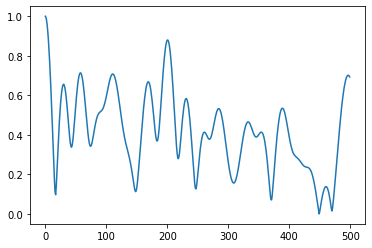

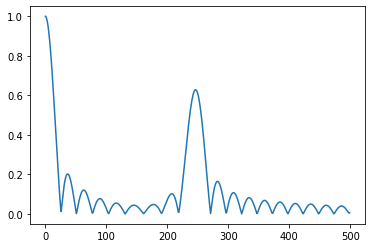

[]

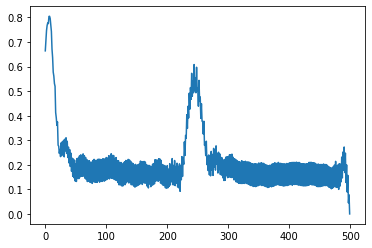

In [ ]:
case = 19  # Fault Code
axis = 0  # ax, ay, az

demo_noisy, demo_clean = preview_case(case)

_noisy = preprocess_single_data(demo_noisy.T)
_clean = preprocess_single_data(demo_clean.T)
_clean_pred = dae.predict(_noisy[None, :]).squeeze()

_noisy = _noisy.T[axis]
_clean = _clean.T[axis]
_clean_pred = _clean_pred.T[axis]

print(_noisy.shape)
print(_clean.shape)
print(_clean_pred.shape)

plt.plot(_noisy)
plt.show()
plt.plot(_clean)
plt.show()
plt.plot(_clean_pred)
plt.plot()

# Fault Classification

In [ ]:
dae = load_model('dae_1200_1e-3.h5')
print(dae.summary())

OSError: ignored

In [ ]:
std = StandardScaler()
mms = MinMaxScaler()


def preprocess_single_data(data):
  global mms, dae
  data = signal.resample(data, 200, axis=0)
  data = np.abs(rfft(data, n=NFT, axis=0))
  data = data[:1200]
  # data = std.fit_transform(data)
  data = data[None, ...]
  # data = mms.fit_transform(data)
  # data = dae.predict(data[None, :])
  return data


class DenoisedDataset():
  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    fname, label, froot = self.df.iloc[idx].tolist()
    fname = fname.replace('test', 'train')
    data = load_fix_df(froot, fname, label=False)
    data = np.stack([data['ax'].to_numpy(), data['ay'].to_numpy(), data['az'].to_numpy()], axis=1)
    data = preprocess_single_data(data)
    label = int(label)
    return data, label

  def __call__(self):
    for i in range(self.__len__()):
      yield self.__getitem__(i)

In [ ]:
class DeepConvNet:
    def __init__(self,
                input_shape=(1,20,400),
                num_class=2,
                loss='sparse_categorical_crossentropy',
                epochs=300,
                batch_size=512,
                optimizer = Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                lr=0.01,
                min_lr=0.01,
                factor=0.25,
                patience=10,
                es_patience=30,
                verbose=1,
                log_path='logs',
                model_name='DeepConvNet',
                **kwargs):
        self.input_shape = input_shape
        self.num_class = num_class
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.optimizer.lr = lr
        self.lr = lr
        self.min_lr = min_lr
        self.factor = factor
        self.patience = patience
        self.es_patience = es_patience
        self.verbose = verbose
        self.log_path = log_path
        self.model_name = model_name
        self.weights_dir = log_path+'/'+model_name+'_out_weights.h5'
        self.csv_dir = log_path+'/'+model_name+'_out_log.log'
        self.time_log = log_path+'/'+model_name+'_time_log.csv'

        # use **kwargs to set the new value of below args.
        self.kernLength = 125
        self.F1 = 8
        self.D = 2
        self.F2 = int(self.F1*self.D)
        self.norm_rate = 0.25
        self.dropout_rate = 0.5
        self.f1_average = 'binary' if self.num_class == 2 else 'macro'
        self.data_format = 'channels_first'
        self.shuffle = False
        self.metrics = 'accuracy'
        self.monitor = 'val_loss'
        self.mode = 'min'
        self.save_best_only = True
        self.save_weight_only = True
        self.seed = 1234
        self.class_balancing = False
        self.class_weight = None

        for k in kwargs.keys():
            self.__setattr__(k, kwargs[k])
            
        if self.data_format == 'channels_first':
            self.Chans = self.input_shape[1]
            self.Samples = self.input_shape[2]
        else:
            self.Chans = self.input_shape[0]
            self.Samples = self.input_shape[1]

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)
        K.set_image_data_format(self.data_format)
        if not os.path.exists(self.log_path):
            os.makedirs(self.log_path)

    def build(self):
        """ Keras implementation of the Deep Convolutional Network as described in
        Schirrmeister et. al. (2017), Human Brain Mapping.
        This implementation assumes the input is a 2-second EEG signal sampled at
        128Hz, as opposed to signals sampled at 250Hz as described in the original
        paper. We also perform temporal convolutions of length (1, 5) as opposed
        to (1, 10) due to this sampling rate difference.
        Note that we use the max_norm constraint on all convolutional layers, as
        well as the classification layer. We also change the defaults for the
        BatchNormalization layer. We used this based on a personal communication
        with the original authors.
                          ours        original paper
        pool_size        1, 2        1, 3
        strides          1, 2        1, 3
        conv filters     1, 5        1, 10
        Note that this implementation has not been verified by the original
        authors.
        """

        # start the model
        input_main   = Input(self.input_shape)
        block1       = Conv2D(25, (1, 5),
                              input_shape=(self.input_shape),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(input_main)
        block1       = Conv2D(25, (self.Chans, 1),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
        block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
        block1       = Activation('elu')(block1)
        block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
        block1       = Dropout(self.dropout_rate)(block1)

        block2       = Conv2D(50, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
        block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
        block2       = Activation('elu')(block2)
        block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
        block2       = Dropout(self.dropout_rate)(block2)

        block3       = Conv2D(100, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block2)
        block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
        block3       = Activation('elu')(block3)
        block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
        block3       = Dropout(self.dropout_rate)(block3)

        block4       = Conv2D(200, (1, 5),
                              kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block3)
        block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
        block4       = Activation('elu')(block4)
        block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
        block4       = Dropout(self.dropout_rate)(block4)

        flatten      = Flatten()(block4)

        dense        = Dense(self.num_class, kernel_constraint = max_norm(0.5))(flatten)
        softmax      = Activation('softmax')(dense)

        return Model(inputs=input_main, outputs=softmax)

    def fit(self, data_train, data_val):

        # if X_train.ndim != 4:
        #     raise Exception('ValueError: `X_train` is incompatible: expected ndim=4, found ndim='+str(X_train.ndim))
        # elif X_val.ndim != 4:
        #     raise Exception('ValueError: `X_val` is incompatible: expected ndim=4, found ndim='+str(X_val.ndim))

        # self.input_shape = X_train.shape[1:]
        # if self.data_format == 'channels_first':
        #     self.Chans = self.input_shape[1]
        #     self.Samples = self.input_shape[2]
        # else:
        #     self.Chans = self.input_shape[0]
        #     self.Samples = self.input_shape[1]
        
        csv_logger = CSVLogger(self.csv_dir)
        time_callback = TimeHistory(self.time_log)
        checkpointer = ModelCheckpoint(monitor=self.monitor, filepath=self.weights_dir, verbose=self.verbose, 
                                       save_best_only=self.save_best_only, save_weight_only=self.save_weight_only)
        reduce_lr = ReduceLROnPlateau(monitor=self.monitor, patience=self.patience, factor=self.factor, mode=self.mode, 
                                      verbose=self.verbose, min_lr=self.min_lr)
        es = EarlyStopping(monitor=self.monitor, mode=self.mode, verbose=self.verbose, patience=self.es_patience)

        model = self.build()
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        model.summary()
        
        # if self.class_balancing: # compute_class_weight if class_balancing is True
        #     self.class_weight = compute_class_weight(y_train)
        # else:
        self.class_weight = None
            
        model.fit(data_train,
                  batch_size=self.batch_size, shuffle=self.shuffle,
                  epochs=self.epochs, validation_data=data_val, class_weight=self.class_weight,
                  callbacks=[checkpointer,csv_logger,reduce_lr,es, time_callback])

    def evaluate(self, data_test):

        # if X_test.ndim != 4:
        #     raise Exception('ValueError: `X_test` is incompatible: expected ndim=4, found ndim='+str(X_test.ndim))

        model = self.build()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)

        # start = time.time()
        # y_pred = model.predict(X_test)
        # end = time.time()
        loss, accuracy = model.evaluate(data_test, batch_size=self.batch_size, verbose=self.verbose)
        # y_pred_argm = np.argmax(y_pred, axis=1)
        # print(classification_report(y_test, y_pred_argm))
        # print("F1-score is computed based on {}".format(self.f1_average))
        # f1 = f1_score(y_test, y_pred_argm, average=self.f1_average)
        # evaluation = {'loss': loss, 
        #               'accuracy': accuracy, 
        #               'f1-score': f1, 
        #               'prediction_time': end-start}
        # Y = {'y_true': y_test, 
        #      'y_pred': y_pred_argm}
        return loss, accuracy

    def predict(self, X_test):
        model = self.build()
        model.load_weights(self.weights_dir)
        model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)

        # start = time.time()
        # y_pred = model.predict(X_test)
        # end = time.time()
        Y_pred = model.predict(X_test, batch_size=self.batch_size, verbose=self.verbose)
        return Y_pred

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

model = DeepConvNet(
  input_shape=(1, 1200, 3), 
  num_class=29, 
  dropout_rate=0.7, 
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  shuffle=True, 
  min_lr=1e-5, 
  data_format='channels_last'
)

In [ ]:
OS = (
  tf.TensorSpec(shape=(1, 1200, 3), dtype=tf.float32),
  tf.TensorSpec(shape=(), dtype=tf.int64)
)

df_train = df_all[df_all['label']!=29]

df_train, df_test = train_test_split(df_train, test_size=0.30, shuffle=True)
df_valid, df_test = train_test_split(df_test, test_size=0.50, shuffle=False)

train_generator = DenoisedDataset(df_train)
valid_generator = DenoisedDataset(df_valid)
train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=OS).batch(BATCH_SIZE)
valid_dataset = tf.data.Dataset.from_generator(valid_generator, output_signature=OS).batch(BATCH_SIZE)

In [ ]:
history = model.fit(train_dataset, valid_dataset)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1200, 3)]      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 1196, 25)       400       
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1196, 25)       650       
                                                                 
 batch_normalization_8 (Batc  (None, 1, 1196, 25)      4         
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 1, 1196, 25)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 598, 25)       0         
 2D)                                                       

KeyboardInterrupt: ignored

In [ ]:
test_generator = DenoisedDataset(df_test)
test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=OS).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=OS).batch(BATCH_SIZE)
loss, accuracy = model.evaluate(test_dataset)
print(loss, accuracy)

In [ ]:
case = 23  # Fault Code
axis = 0  # ax, ay, az

demo_noisy, demo_clean = preview_case(case)

_noisy = preprocess_single_data(demo_noisy.T)
_clean = preprocess_single_data(demo_clean.T)
_clean_pred = dae.predict(_noisy[None, :])
pred_scores = model.predict(_clean_pred).squeeze()
prediction = pred_scores.argmax()

print(prediction)
plt.hist(pred_scores, bin=29, range=(0, 29))
plt.show()

# Test Prediction and Submission

In [ ]:
dae = load_model()
print(dae.summary())

In [ ]:
model = load_model('logs/DeepConvNet_out_weights.h5')
print(model.summary())

In [ ]:
mms = MinMaxScaler()
std = StandardScaler()

filenames = [f'test_data{i}.csv' for i in range(1, 9001)]
predictions = []

for fname in tqdm(filenames):
  data = load_fix_df(f'test_data/{fname}', label=False)
  data = np.stack([data['ax'].to_numpy(), data['ay'].to_numpy(), data['az'].to_numpy()], axis=0)
  data = signal.resample(data, 200, axis=0)
  data = np.abs(rfft(data, n=NFT, axis=0))
  data = data[:1200]
  data = mms.fit_transform(data)
  data = dae.predict(data[None, :])
  pred_scores = model.predict(data).squeeze()
  prediction = data.argmax()
  '''
  In case rule-based scores are made for class 29.
  '''
  predictions.append(prediction)


print(len(predictions))
print(predictions[:5])

  0%|          | 0/9000 [00:00<?, ?it/s]

9000
[array([[3.94521106e-16, 2.92880477e-11, 1.25845029e-11, 1.04931439e-12,
        2.69413022e-07, 5.33021516e-10, 2.74587399e-03, 3.13540477e-05,
        1.11733627e-07, 4.81699316e-13, 2.37897392e-02, 4.21104801e-07,
        1.44576840e-03, 8.61436206e-07, 3.49451067e-12, 5.20784587e-13,
        7.35296112e-12, 3.27622484e-17, 1.84111767e-10, 4.03946530e-07,
        1.04685316e-09, 2.57107982e-04, 1.04403566e-03, 7.50068071e-14,
        4.19905355e-09, 9.80850928e-06, 9.90652293e-02, 8.71495128e-01,
        1.13892565e-04]], dtype=float32), array([[3.3484854e-16, 1.9323797e-10, 5.4722459e-11, 7.0869868e-12,
        2.1808482e-07, 5.3798698e-11, 7.2226953e-04, 5.4569406e-05,
        2.7164995e-07, 1.7068597e-12, 4.8504710e-02, 2.7384010e-07,
        2.4305934e-03, 4.8156576e-06, 4.2667645e-12, 1.1426838e-12,
        1.3149331e-11, 1.7653819e-17, 2.2600168e-10, 1.3001452e-06,
        1.3250984e-09, 8.5378219e-05, 7.7227416e-04, 7.4914975e-14,
        5.2765738e-09, 1.9957395e-05, 9.

In [ ]:
predictions = [i.argmax() for i in predictions]

In [ ]:
print(predictions[:5])

[27, 27, 27, 27, 27]


In [ ]:
plt.hist(predictions, bins=30, range=(0, 30))
plt.show()

In [ ]:
df_submission = pd.DataFrame({"filename": filenames, "code": predictions}).astype(str)
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9000 non-null   object
 1   code      9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [ ]:
df_submission.head()

,filename,code
0,test_data1.csv,19
1,test_data2.csv,14
2,test_data3.csv,19
3,test_data4.csv,9
4,test_data5.csv,17


In [ ]:
df_submission.tail()

,filename,code
8995,test_data8996.csv,28
8996,test_data8997.csv,21
8997,test_data8998.csv,23
8998,test_data8999.csv,23
8999,test_data9000.csv,19


In [ ]:
df_submission.to_csv('dummy_submission.csv', index=False)